In [24]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import trange
from sklearn import datasets

In [25]:
#pip install ucimlrepo

In [26]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_landsat_satellite = fetch_ucirepo(id=146) 
  
# data (as pandas dataframes) 
A_statlog = statlog_landsat_satellite.data.features # (6435, 36)
Y_statlog = statlog_landsat_satellite.data.targets.squeeze() #(6435,)


In [27]:
# Preprocessing of satellite image data

# normalize each value by dividing by 255

A_statlog = A_statlog / 255.0

In [28]:
# Define Global Parameters

NUM_FEATURES = 1000
NUM_SAMPLES = 1000
NUM_CLASSES = 50

In [29]:
# Steps 1 and 2

A = np.random.randn(NUM_SAMPLES, NUM_FEATURES)

X = np.random.randn(NUM_FEATURES, NUM_CLASSES)
W = np.random.randn(NUM_FEATURES, NUM_CLASSES) # additional weight matrix

E = np.random.randn(NUM_SAMPLES, NUM_CLASSES)

# Even though we'll use X in algorithms, we won't use it in the initialization of B
B = A.dot(W) + E

In [30]:
Y = np.argmax(B, axis=1) 

# Y one-hot encoding
# Set maximum value of each row to 1 and others to 0
Y_oh = (B == B.max(axis=1, keepdims=1)).astype(int)

# Second version of one-hot encoding
Y_one_hot = np.zeros((NUM_SAMPLES, NUM_CLASSES))
Y_one_hot[np.arange(NUM_SAMPLES), Y] = 1

In [31]:
# an alternative way to calculate fisrt term of loss function using matrix multiplication 
T=A.dot(X)
Fi=T[np.arange(NUM_SAMPLES), Y]

In [32]:
# Define Multiclass Logistic Regression Loss Function
def loss(X,A=A):
    AX=A.dot(X)
    first_term=AX[np.arange(A.shape[0]), Y]
    #first_term = (A * X.T[Y]).sum(axis=-1)
    # asterisk is element-wise multiplication

    second_term = np.log(np.exp(AX).sum(axis=-1))
    # dot product is matrix multiplication since we are doing it across all classes 

    return (-first_term + second_term).sum()
    # summing across all samples

In [33]:
def gradient(X,A=A):
    AX = A.dot(X)
    # just perform matrix multiplication one time to reduce complexity
    soft_max = np.exp(AX) / (np.exp(AX).sum(axis=-1, keepdims=True)+1e-4)
    # keepdims is used to keep the dimensions of X to align with Y_oh
    return A.T.dot(soft_max - Y_oh)
    #final dimensions should be NUM_FEATURES x NUM_CLASSES 

In [53]:
A.shape

(1000, 1000)

In [55]:
AX =og.dot(X_statlog)

,0,1,2,3,4,5,6
0,-2.579870,2.377672,-0.265486,0.940126,2.969780,-3.989947,0.565940
1,-2.569789,2.197756,-0.126312,1.119545,2.919541,-3.654672,0.573991
2,-2.237665,2.024551,-0.211875,1.219158,2.823728,-3.573832,0.613047
3,-2.126698,2.010838,-0.255090,1.288297,2.864024,-3.543159,0.487982
4,-2.065430,2.079353,-0.331306,1.283904,2.949466,-3.637633,0.427436
...,...,...,...,...,...,...,...
6430,-1.996224,2.218986,-0.555908,0.876255,2.594566,-3.324086,0.269550
6431,-1.856862,2.147967,-0.699466,0.802331,2.257337,-3.214479,0.077950
6432,-1.715001,2.107749,-0.672263,0.651697,2.122339,-2.910226,0.099290
6433,-1.716324,2.267461,-0.656190,0.910440,2.282478,-3.049775,0.420919


In [34]:
# Create copy of X to test different gradient algorithms
X_GD = X.copy()
X_BCGD_R = X.copy()
X_BCGD_GS = X.copy()

In [35]:
# Step 3A: Gradient Descent

# Set parameters for gradient descent
max_iter = 500
# static learning rate for now
learning_rate = 0.001

losses = []
times = []
accuracies = []

start_time = time.time()

for i in trange(max_iter):
    # every iteration calculate gradient and update X
    X_GD -= learning_rate * gradient(X_GD)
    # calculate loss and accuracy every 1 iteration
    if i % 1 == 0:
        losses.append(loss(X_GD))
        times.append(time.time() - start_time)
        accuracies.append((Y == np.argmax(A.dot(X_GD), axis=1)).mean())

100%|██████████| 500/500 [00:09<00:00, 52.00it/s]


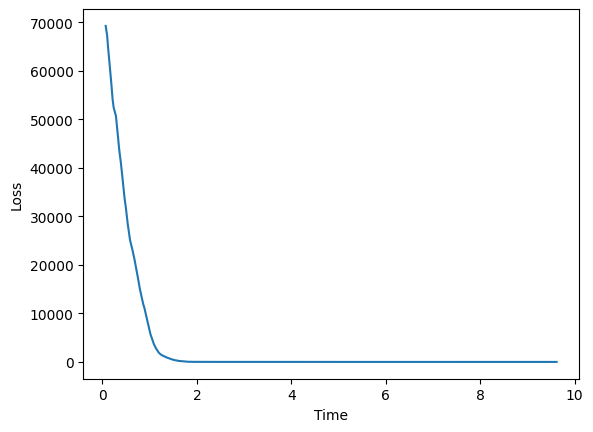

In [36]:
# synthetic dataset
plt.plot(times, losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

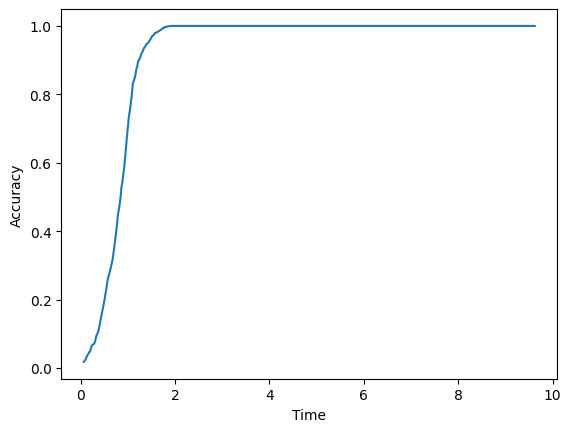

In [39]:
# synthetic dataset
plt.plot(times, accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

In [40]:
# Gradient for Block Coordinate Algorithms
# We define a block as a COLUMN of X, or a class
# Required params are weight matrix X and the block index

def gradient_bcgd(X, block):
    AX = A.dot(X)
    soft_max = np.exp(AX[:,block]) / (np.exp(AX).sum(axis=-1)+1e-4)
    # only calculate the softmax and gradient for the block
    return A.T.dot(soft_max - Y_oh[:,block])


In [41]:
# Step 3B: BCGD with Randomized Block Selection

# Set parameters for BCGD with Randomized Block Selection
max_iter = 500
learning_rate = 0.001

bcgd_r_losses = []
bcgd_r_times = []
bcgd_r_accuracies = []

start_time = time.time()

for i in trange(max_iter):
    # for every iteration, we iterate through all blocks to align with full gradient descent updates
    for j in range(NUM_CLASSES):
        # randomly select a block to update
        block = np.random.randint(0, NUM_CLASSES)
        # update the gradient just for the block
        X_BCGD_R[:, block] -= learning_rate * gradient_bcgd(X_BCGD_R, block)
    # append loss, time, accuracy 
    if i % 1 == 0:
        bcgd_r_losses.append(loss(X_BCGD_R))
        bcgd_r_times.append(time.time() - start_time)
        bcgd_r_accuracies.append((Y == np.argmax(A.dot(X_BCGD_R), axis=1)).mean())

100%|██████████| 500/500 [01:24<00:00,  5.92it/s]


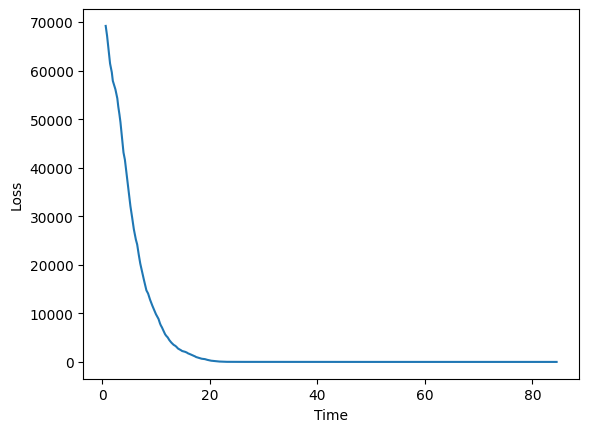

In [42]:
plt.plot(bcgd_r_times, bcgd_r_losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

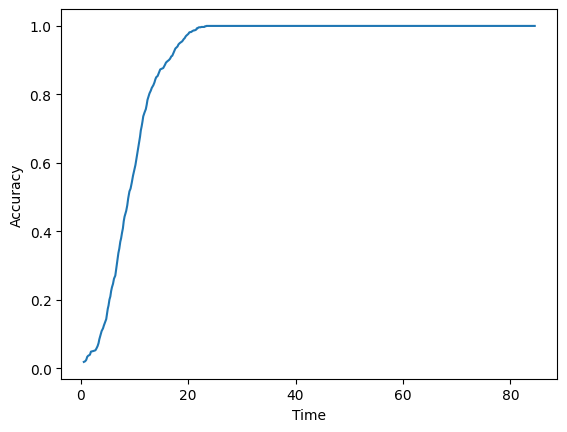

In [43]:
plt.plot(bcgd_r_times, bcgd_r_accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

In [44]:
# Step 3C: BCGD with GS Block Selection
X_BCGD_GS = X.copy()

# Gradient Descent
max_iter = 500
learning_rate = 0.001

bcgd_gs_losses = []
bcgd_gs_times = []
bcgd_gs_accuracies = []

unnormalized_prob = np.exp(A.dot(X_BCGD_GS)) # numerator
normalizer = unnormalized_prob.sum(axis=1, keepdims = True) # denominator

start_time = time.time()

for i in trange(max_iter,smoothing=0.):
    for j in range(NUM_CLASSES):
        grad = A.T.dot(unnormalized_prob/(normalizer+1e-4) - Y_oh)
        block = np.argmax(np.linalg.norm(grad, axis=0))
        block_grad = grad[:,block]
        pre_update = unnormalized_prob[:,block].copy()#to remmove it from the denominator and substitute the new part 
        X_BCGD_GS[:,block] -= learning_rate * block_grad
        unnormalized_prob[:,block] = np.exp(A.dot(X_BCGD_GS[:,block]))#we update the block in the matrix which contains the numerators of the softmax 
        #to avoid a full matrix multiplication 
        normalizer += unnormalized_prob[:,block,None] - pre_update[...,None]
        
    if i % 1 == 0:
        bcgd_gs_losses.append(loss(X_BCGD_GS))
        bcgd_gs_times.append(time.time() - start_time)
        bcgd_gs_accuracies.append((Y == np.argmax(A.dot(X_BCGD_GS), axis=1)).mean())


100%|██████████| 500/500 [01:13<00:00,  6.82it/s]


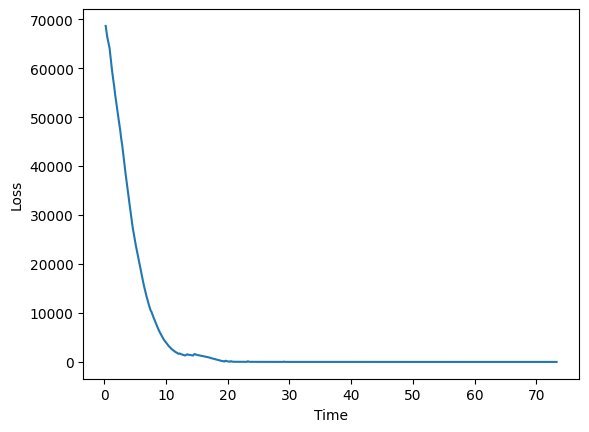

In [45]:
plt.plot(bcgd_gs_times, bcgd_gs_losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

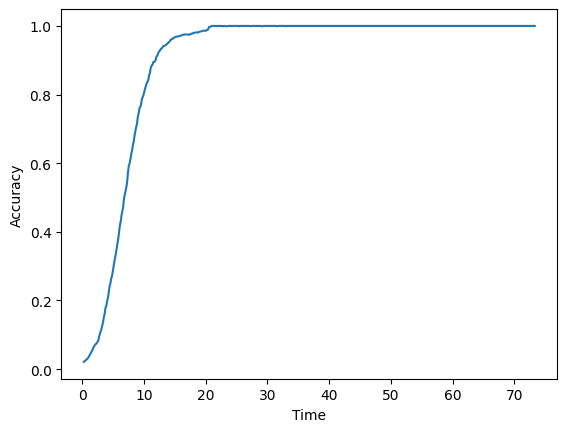

In [46]:
plt.plot(bcgd_gs_times, bcgd_gs_accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

## Implementation on real-life data 

In [47]:
np.random.seed(23)

#define dimensions for the real data 
num_samples=A_statlog.shape[0]
num_features=A_statlog.shape[1]
num_classes=7

#randomly generate the parameters matrix
X_statlog = np.random.randn(num_features,num_classes)
W_statlog = np.random.randn(num_features, num_classes) # additional weight matrix

E_statlog = np.random.randn(num_samples, num_classes)

# Even though we'll use X in algorithms, we won't use it in the initialization of B
B_statlog = A_statlog.dot(W_statlog) + E_statlog


In [48]:
Y = np.argmax(B_statlog, axis=1) 

# Y one-hot encoding
# Set maximum value of each row to 1 and others to 0
#Y_oh = (B_statlog == B_statlog.max(axis=1, keepdims=1)).astype(int)

# Second version of one-hot encoding
Y_oh = np.zeros((num_samples, num_classes))
Y_oh[np.arange(num_samples), Y] = 1

In [49]:
Y_oh.shape

(6435, 7)

In [50]:
# Create copy of X to test different gradient algorithms
X_GD_statlog = X_statlog.copy()
X_BCGD_R_statlog = X_statlog.copy()
X_BCGD_GS_statlog = X_statlog.copy()

### Gradient Descent for real data

In [52]:
#  Gradient Descent

# Set parameters for gradient descent
max_iter = 5000
# static learning rate for now
learning_rate = 0.0001

losses = []
times = []
accuracies = []

start_time = time.time()

for i in trange(max_iter):
    # every iteration calculate gradient and update X
    X_GD_statlog -= learning_rate * gradient(X_GD_statlog, A=A_statlog)
    # calculate loss and accuracy every 1 iteration
    if i % 1 == 0:
        losses.append(loss(X_GD_statlog,A=A_statlog))
        times.append(time.time() - start_time)
        accuracies.append((Y_statlog == np.argmax(A_statlog.dot(X_GD_statlog), axis=1)).mean())

  0%|          | 0/5000 [00:00<?, ?it/s]


ValueError: the 'keepdims' parameter is not supported in the pandas implementation of sum()

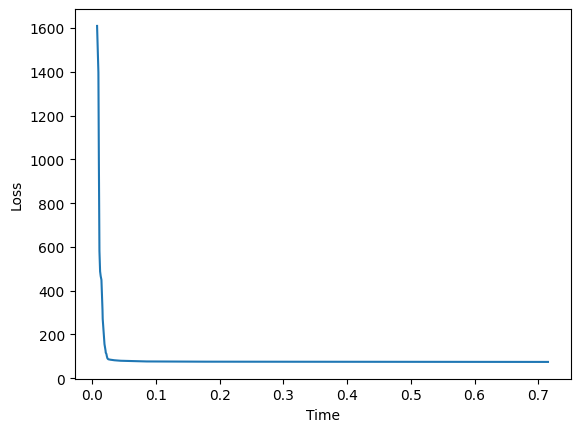

In [ ]:
# real dataset
plt.plot(times, losses)
plt.xlabel('Time')
plt.ylabel('Loss')
plt.show()

In [ ]:
losses[-1]

74.24864011315857

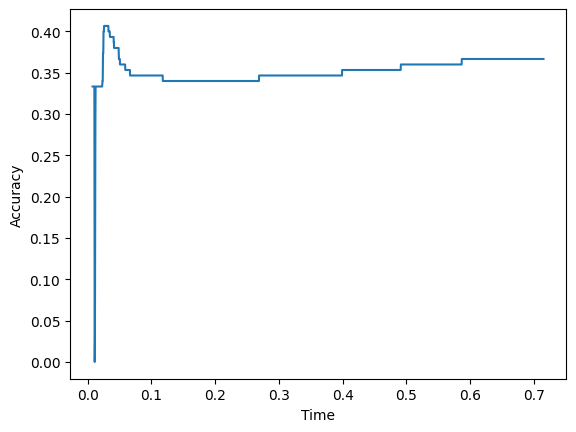

In [ ]:
# real dataset
plt.plot(times, accuracies)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()